<a href="https://colab.research.google.com/github/NAZTEMUCIN/ibmcerfiticate/blob/master/organon_case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from time import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('/content/2_Modelling_Question_Dataset.csv')
data.head()

,RECORD_ID,AGE,WORKCLASS,FNLWGHT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,COUNTRY,PROXY,TARGET
0,1,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,2,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,3,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,4,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,5,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


EDA

In [3]:
# Total number of data
n_records = data.shape[0]
print('numberof_records:',n_records)
# Number of data where people's income is more than $50,000
n_greater_50k = data[data['PROXY'] == '>50K'].shape[0]
print('income_greater_50k:',n_greater_50k)
# Number of data where people's income is at most $50,000
n_at_most_50k = data[data['PROXY'] == '<=50K'].shape[0]
print('income_at_most_50k:',n_at_most_50k)
# Percentage of people whose income is more than $50,000
greater_percent = (n_greater_50k / n_records) * 100
print('greater_percentage:',greater_percent)

numberof_records: 32561
income_greater_50k: 7841
income_at_most_50k: 24720
greater_percentage: 24.080955744602438


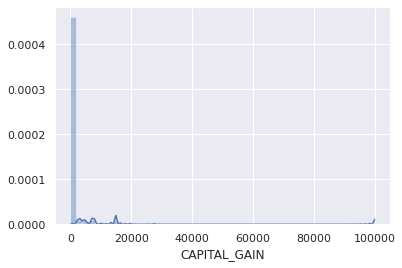

In [4]:
sns.set(color_codes=True)
sns.distplot(data['CAPITAL_GAIN'])

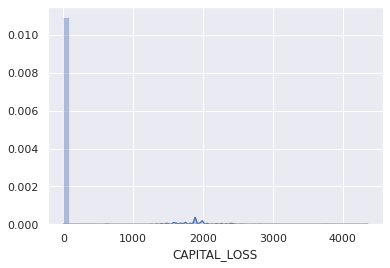

In [5]:
sns.distplot(data['CAPITAL_LOSS'])

Split the data into features and target label

In [0]:
income_raw = data['PROXY']
features_raw = data.drop('PROXY', axis = 1)

Log-transform the skewed features. For this type of disttributions, is very typical to apply logarithmic transformationon the data, so the outliers do not affect negatively the machine learning model’s performance.

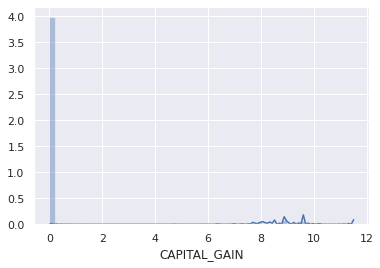

In [7]:
skewed = ['CAPITAL_GAIN', 'CAPITAL_LOSS']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

sns.distplot(features_log_transformed["CAPITAL_GAIN"])

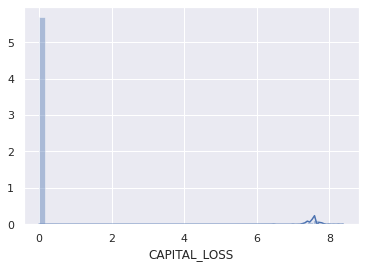

In [8]:
sns.distplot(features_log_transformed["CAPITAL_LOSS"])

In [9]:
scaler = MinMaxScaler()
scaled_variables = ['AGE', 'EDUCATION_NUM', 'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK']
features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[scaled_variables] = scaler.fit_transform(features_log_transformed[scaled_variables])

# Scaled
display(features_log_minmax_transform.head(n = 5))

,RECORD_ID,AGE,WORKCLASS,FNLWGHT,EDUCATION,EDUCATION_NUM,MARITAL_STATUS,OCCUPATION,RELATIONSHIP,RACE,SEX,CAPITAL_GAIN,CAPITAL_LOSS,HOURS_PER_WEEK,COUNTRY,TARGET
0,1,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States,0
1,2,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States,0
2,3,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States,0
3,4,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States,0
4,5,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba,0


Preprocessing Categorial Features

Converging categorical variables to numeric 


In [10]:
# Encode the 'income_raw' data to numerical values
income = income_raw.map({'<=50K':0,'>50K':1})
print('Number of data: ',n_records)
# One-hot encode the 'features_log_minmax_transform' data 
features_final = pd.get_dummies(features_log_minmax_transform)
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))
print (encoded)

Number of data:  32561
110 total features after one-hot encoding.
['RECORD_ID', 'AGE', 'FNLWGHT', 'EDUCATION_NUM', 'CAPITAL_GAIN', 'CAPITAL_LOSS', 'HOURS_PER_WEEK', 'TARGET', 'WORKCLASS_?', 'WORKCLASS_Federal-gov', 'WORKCLASS_Local-gov', 'WORKCLASS_Never-worked', 'WORKCLASS_Private', 'WORKCLASS_Self-emp-inc', 'WORKCLASS_Self-emp-not-inc', 'WORKCLASS_State-gov', 'WORKCLASS_Without-pay', 'EDUCATION_10th', 'EDUCATION_11th', 'EDUCATION_12th', 'EDUCATION_1st-4th', 'EDUCATION_5th-6th', 'EDUCATION_7th-8th', 'EDUCATION_9th', 'EDUCATION_Assoc-acdm', 'EDUCATION_Assoc-voc', 'EDUCATION_Bachelors', 'EDUCATION_Doctorate', 'EDUCATION_HS-grad', 'EDUCATION_Masters', 'EDUCATION_Preschool', 'EDUCATION_Prof-school', 'EDUCATION_Some-college', 'MARITAL_STATUS_Divorced', 'MARITAL_STATUS_Married-AF-spouse', 'MARITAL_STATUS_Married-civ-spouse', 'MARITAL_STATUS_Married-spouse-absent', 'MARITAL_STATUS_Never-married', 'MARITAL_STATUS_Separated', 'MARITAL_STATUS_Widowed', 'OCCUPATION_?', 'OCCUPATION_Adm-clerical',

Naive Predictor Performance

In [11]:
true_positive = np.sum(income)
false_positive = income.count() - true_positive
true_negative = 0
false_negative = 0
beta = 0.5
accuracy  = true_positive / (true_positive + false_positive + true_negative + false_negative )
recall = true_positive / (true_positive + false_negative)
precision = true_positive / (true_positive + false_positive)
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2) * precision + recall))
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2408, F-score: 0.2839]


Split train and test data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features_final, income, test_size = 0.2, random_state = 0)  
print("Training set has {} samples.".format(X_train.shape[0])) 
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 26048 samples.
Testing set has 6513 samples.


In [0]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 

  # Calculate the number of samples for 1%, 10%, 50% and 100% of the training data
  size_options = [sample_size, int(sample_size/2), int(sample_size/10),int(sample_size/100)]
  for sample_size in size_options:
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    results['acc_train'] = accuracy_score(y_train, predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    print("{} has training accuracy score: {}".format(learner.__class__.__name__, results['acc_train']))
    print("{} has test accuracy score: {}".format(learner.__class__.__name__, results['acc_test']))
    print("{} train set F-Score: {}".format(learner.__class__.__name__, results['f_train']))
    print("{} test set F-Score: {}".format(learner.__class__.__name__, results['f_test']))
    print("------------------------------")
  return results

In [14]:
# Initialize the three models
random_state = 42
sample_size = len(y_train)
clf_A = RandomForestClassifier(random_state=random_state)
clf_B = GaussianNB()
clf_C = SVC(random_state=random_state)
results = {}
for clf in [clf_A, clf_B, clf_C]:
  start = time() # Get start time to measure performance
  results[clf] = train_predict(clf, sample_size, X_train, y_train, X_test, y_test)
  end = time()
  total_time = end-start
  print('{} training time: {}'.format(clf.__class__.__name__,total_time))
  print('*********************************************')


RandomForestClassifier trained on 26048 samples.
RandomForestClassifier has training accuracy score: 1.0
RandomForestClassifier has test accuracy score: 1.0
RandomForestClassifier train set F-Score: 1.0
RandomForestClassifier test set F-Score: 1.0
------------------------------
RandomForestClassifier trained on 13024 samples.
RandomForestClassifier has training accuracy score: 1.0
RandomForestClassifier has test accuracy score: 1.0
RandomForestClassifier train set F-Score: 1.0
RandomForestClassifier test set F-Score: 1.0
------------------------------
RandomForestClassifier trained on 2604 samples.
RandomForestClassifier has training accuracy score: 1.0
RandomForestClassifier has test accuracy score: 1.0
RandomForestClassifier train set F-Score: 1.0
RandomForestClassifier test set F-Score: 1.0
------------------------------
RandomForestClassifier trained on 260 samples.
RandomForestClassifier has training accuracy score: 1.0
RandomForestClassifier has test accuracy score: 1.0
RandomFor

Based on the results of the evaluation;
1. Random Forest Classifier and Support Vector Machine models are the most appropiate models to identify potential donors according to their F-Scores.
2. Random Forest Classifier performs almost 30 times faster than SVM.

To sum up, the best model for this data set is Random Forest Classifier.


In [0]:
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training 
model = AdaBoostClassifier().fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

In [16]:
importances

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])